In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available.")

/home/apakiman/anaconda3/envs/TF-keras/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-23 16:16:42.088307: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 16:16:42.192714: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 16:16:42.193864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:16:43.614290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No GPUs available.


2023-08-23 16:16:44.698414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 16:16:44.699581: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
(dataset_train_original, dataset_validate_original), infor = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[90%:]"], # pretending we don't have a big dataset
                                          # dataset is already shuffled
    as_supervised=True,
    with_info=True
)

# Note
Do caching before augmentation, no augmentation on validation

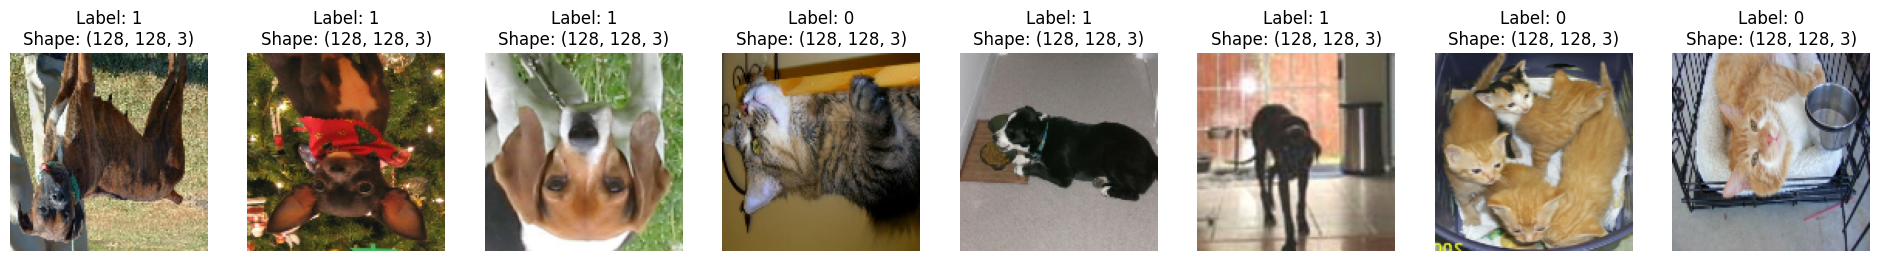

In [3]:
def encode(image, label, image_size=(128, 128)):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size)
    return image, label
dataset = dataset_train_original.map(lambda image, label: encode(image, label))

def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    return image_augmented, label

dataset = dataset_train_original.map(lambda image, label: encode(image, label))
dataset = dataset.map(lambda image, label: augment(image, label))

num_samples = 8
index = 1
plt.figure(figsize=(24, 4))
for image, label in dataset.take(num_samples):
    plt.subplot(1, num_samples, index)
    plt.imshow(image)
    plt.title(f"Label: {label}\nShape: {image.shape}")
    plt.axis("off")
    index += 1

In [4]:
dataset_train_augmented = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train_augmented = dataset_train_augmented.cache()
dataset_train_augmented = dataset_train_augmented.map(lambda image, label: augment(image, label))
dataset_train_augmented = dataset_train_augmented.shuffle(2500)
dataset_train_augmented = dataset_train_augmented.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

# Transfer Learning

In [5]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.VGG16()
base_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.VGG16(
    input_shape = (128, 128, 3),# add the input layer, cant change input_shape without 
                                # include_top=False, due to FC layers number of parameters
    include_top = False,        # skip the input layer
)
base_net.trainable = False      # freezing the layers

base_net.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [8]:
model = models.Sequential([
    base_net,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15763521 (60.13 MB)
Trainable params: 1048833 (4.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [17]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(    
    dataset_train_augmented,
    epochs=5,
    validation_data=dataset_validate
)

history_list["vgg16+augmunt"] = history.history
render_history(history.history)
compare_histories()

Epoch 1/5


19/19 [==============================] - 256s 14s/step - loss: 0.3827 - accuracy: 0.8293 - val_loss: 0.3054 - val_accuracy: 0.8564
Epoch 2/5
19/19 [==============================] - 241s 13s/step - loss: 0.3006 - accuracy: 0.8680 - val_loss: 0.3027 - val_accuracy: 0.8727
Epoch 3/5
19/19 [==============================] - 239s 13s/step - loss: 0.2582 - accuracy: 0.8895 - val_loss: 0.3128 - val_accuracy: 0.8646
Epoch 4/5
19/19 [==============================] - 241s 13s/step - loss: 0.2520 - accuracy: 0.8942 - val_loss: 0.3121 - val_accuracy: 0.8646
Epoch 5/5
19/19 [==============================] - 240s 13s/step - loss: 0.2699 - accuracy: 0.8844 - val_loss: 0.3372 - val_accuracy: 0.8457


NameError: name 'history_list' is not defined

Other Models: [link](https://keras.io/api/applications/)

In [15]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

In [16]:
compare_histories()

NameError: name 'history_list' is not defined